In [18]:
# GPU Detection & Setup
import torch
import subprocess
import sys

def check_gpu_availability():
    """Check GPU availability for different ML frameworks"""
    gpu_status = {}
    
    # Check CUDA availability
    gpu_status['cuda_available'] = torch.cuda.is_available()
    if gpu_status['cuda_available']:
        gpu_status['gpu_count'] = torch.cuda.device_count()
        gpu_status['gpu_name'] = torch.cuda.get_device_name(0)
        gpu_status['cuda_version'] = torch.version.cuda
    
    # Check XGBoost GPU support specifically
    try:
        from xgboost import XGBClassifier
        test_xgb = XGBClassifier(tree_method='gpu_hist', n_estimators=1)
        # Test with minimal data
        import numpy as np
        X_test = np.array([[1, 2], [3, 4]])
        y_test = np.array([0, 1])
        test_xgb.fit(X_test, y_test)
        gpu_status['xgb_gpu_available'] = True
    except Exception as e:
        gpu_status['xgb_gpu_available'] = False
        gpu_status['xgb_gpu_error'] = str(e)
    
    # Check GPU memory
    try:
        result = subprocess.run(['nvidia-smi', '--query-gpu=memory.total,memory.free', '--format=csv,noheader,nounits'], 
                              capture_output=True, text=True)
        if result.returncode == 0:
            memory_info = result.stdout.strip().split('\n')[0].split(', ')
            gpu_status['total_memory_mb'] = int(memory_info[0])
            gpu_status['free_memory_mb'] = int(memory_info[1])
    except:
        gpu_status['memory_check_failed'] = True
    
    return gpu_status

# Check GPU status
gpu_info = check_gpu_availability()
print("🔧 GPU Configuration Check:")
print(f"   CUDA Available: {gpu_info.get('cuda_available', False)}")
print(f"   XGBoost GPU Support: {gpu_info.get('xgb_gpu_available', False)}")

if gpu_info.get('cuda_available'):
    print(f"   GPU Count: {gpu_info.get('gpu_count', 0)}")
    print(f"   GPU Name: {gpu_info.get('gpu_name', 'Unknown')}")
    print(f"   CUDA Version: {gpu_info.get('cuda_version', 'Unknown')}")
    if 'total_memory_mb' in gpu_info:
        print(f"   GPU Memory: {gpu_info['free_memory_mb']:.0f}MB free / {gpu_info['total_memory_mb']:.0f}MB total")

if not gpu_info.get('xgb_gpu_available', False):
    print(f"   ⚠️ XGBoost GPU Error: {gpu_info.get('xgb_gpu_error', 'Unknown')}")
    print("   💡 Install GPU XGBoost: pip install xgboost[gpu] or use CPU fallback")

# Set GPU usage flags
use_gpu_general = gpu_info.get('cuda_available', False)
use_gpu_xgb = gpu_info.get('xgb_gpu_available', False)

print(f"   🎯 GPU Strategy: LGB/Cat={'GPU' if use_gpu_general else 'CPU'}, XGB={'GPU' if use_gpu_xgb else 'CPU'}")

🔧 GPU Configuration Check:
   CUDA Available: True
   XGBoost GPU Support: False
   GPU Count: 1
   GPU Name: NVIDIA GeForce RTX 3050 6GB Laptop GPU
   CUDA Version: 12.1
   GPU Memory: 5920MB free / 6144MB total
   ⚠️ XGBoost GPU Error: Invalid Input: 'gpu_hist', valid values are: {'approx', 'auto', 'exact', 'hist'}
   💡 Install GPU XGBoost: pip install xgboost[gpu] or use CPU fallback
   🎯 GPU Strategy: LGB/Cat=GPU, XGB=CPU


In [19]:
# Heart Disease Detection v6.0 - Data Integrity Focus
# Goal: Break the 0.955 Public LB barrier and target 0.96+ OOF stability

import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import TargetEncoder
import warnings

warnings.filterwarnings('ignore')

print("🚀 Heart Disease Detection v6.0: Data Integrity Approach")
print("📊 Loading datasets...")

# Load the data (updated paths for local workspace)
train = pd.read_csv('data\\train.csv')
test = pd.read_csv('data\\test.csv')

print(f"✅ Train data: {train.shape}")
print(f"✅ Test data: {test.shape}")

# Clean Target Mapping
target_map = {'Presence': 1, 'Absence': 0, 1: 1, 0: 0}
train['Heart Disease'] = train['Heart Disease'].map(lambda x: target_map.get(x, x)).astype(int)

print(f"📈 Target distribution:\n{train['Heart Disease'].value_counts()}")

🚀 Heart Disease Detection v6.0: Data Integrity Approach
📊 Loading datasets...
✅ Train data: (630000, 15)
✅ Test data: (270000, 14)
📈 Target distribution:
Heart Disease
0    347546
1    282454
Name: count, dtype: int64


In [20]:
# --- ENHANCED FEATURE ENGINEERING & EDA ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import optuna
from optuna.pruners import MedianPruner

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

def inject_truth_anchor(df):
    """
    Injects original UCI Heart Disease dataset as biological "Truth Anchor"
    to ground synthetic distributions in real clinical data.
    """
    # Try to find UCI dataset in common locations
    paths = [
        './data/heart.csv',  # Local data folder
        './heart.csv',       # Root directory
        './uci_heart.csv'    # Alternative naming
    ]
    
    original = None
    for p in paths:
        try:
            original = pd.read_csv(p)
            print(f"📍 Found UCI dataset at: {p}")
            break
        except FileNotFoundError:
            continue
        except Exception as e:
            print(f"⚠️ Error reading {p}: {e}")
            continue
    
    if original is not None:
        # Column mapping from UCI to competition format
        mapping = {
            'age': 'Age', 'sex': 'Sex', 'cp': 'Chest pain type', 
            'trestbps': 'BP', 'chol': 'Cholesterol', 'fbs': 'FBS over 120',
            'restecg': 'EKG results', 'thalach': 'Max HR', 'exang': 'Exercise angina',
            'oldpeak': 'ST depression', 'slope': 'Slope of ST', 'ca': 'Number of vessels fluro',
            'thal': 'Thallium', 'target': 'Heart Disease'
        }
        
        # Apply column mapping if columns exist
        rename_dict = {k: v for k, v in mapping.items() if k in original.columns}
        original = original.rename(columns=rename_dict)
        
        # Ensure target is properly formatted
        if 'Heart Disease' in original.columns:
            original['Heart Disease'] = original['Heart Disease'].astype(int)
        
        # Mark data sources
        original['is_synthetic'] = 0
        df['is_synthetic'] = 1
        
        # Combine datasets
        combined = pd.concat([df, original], axis=0, ignore_index=True)
        print(f"✅ Truth Anchor Injected: Added {len(original)} real clinical records.")
        print(f"📊 Combined dataset: {len(combined)} total records")
        return combined
    else:
        print("⚠️ UCI Dataset not found in local workspace.")
        print("💡 To enhance performance, add UCI Heart Disease dataset to ./data/heart.csv")
        df['is_synthetic'] = 1
        return df

# Apply Truth Anchor Injection
print("\n🔬 Phase 1: Truth Anchor Injection...")
train = inject_truth_anchor(train)
print(f"📊 Final training set shape: {train.shape}")

# Define feature types (enhanced from complete pipeline)
target = "Heart Disease"

numcols = [
    "Age", "BP", "Cholesterol", "Max HR", "ST depression"
]

catcols = [
    "Sex", "Chest pain type", "FBS over 120", "EKG results",
    "Exercise angina", "Slope of ST", "Number of vessels fluro", "Thallium"
]

drop_cols = ["id", "is_synthetic"]

print(f"\n📊 Feature Analysis:")
print(f"   Numerical features: {len(numcols)} - {numcols}")
print(f"   Categorical features: {len(catcols)} - {catcols[:4]}...")
print(f"   Drop columns: {drop_cols}")


🔬 Phase 1: Truth Anchor Injection...
⚠️ UCI Dataset not found in local workspace.
💡 To enhance performance, add UCI Heart Disease dataset to ./data/heart.csv
📊 Final training set shape: (630000, 16)

📊 Feature Analysis:
   Numerical features: 5 - ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
   Categorical features: 8 - ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results']...
   Drop columns: ['id', 'is_synthetic']



⚙️ Phase 2: Exploratory Data Analysis & Feature Engineering...



🎯 Target Analysis:
   Original target encoding: {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}
   Final target distribution: {0: 347546, 1: 282454}

🔍 Feature Correlation Analysis:
   Top correlations with target:
     ST depression: 0.4306
     Age: 0.2121
     Cholesterol: 0.0828
     BP: -0.0052
     Max HR: -0.4410


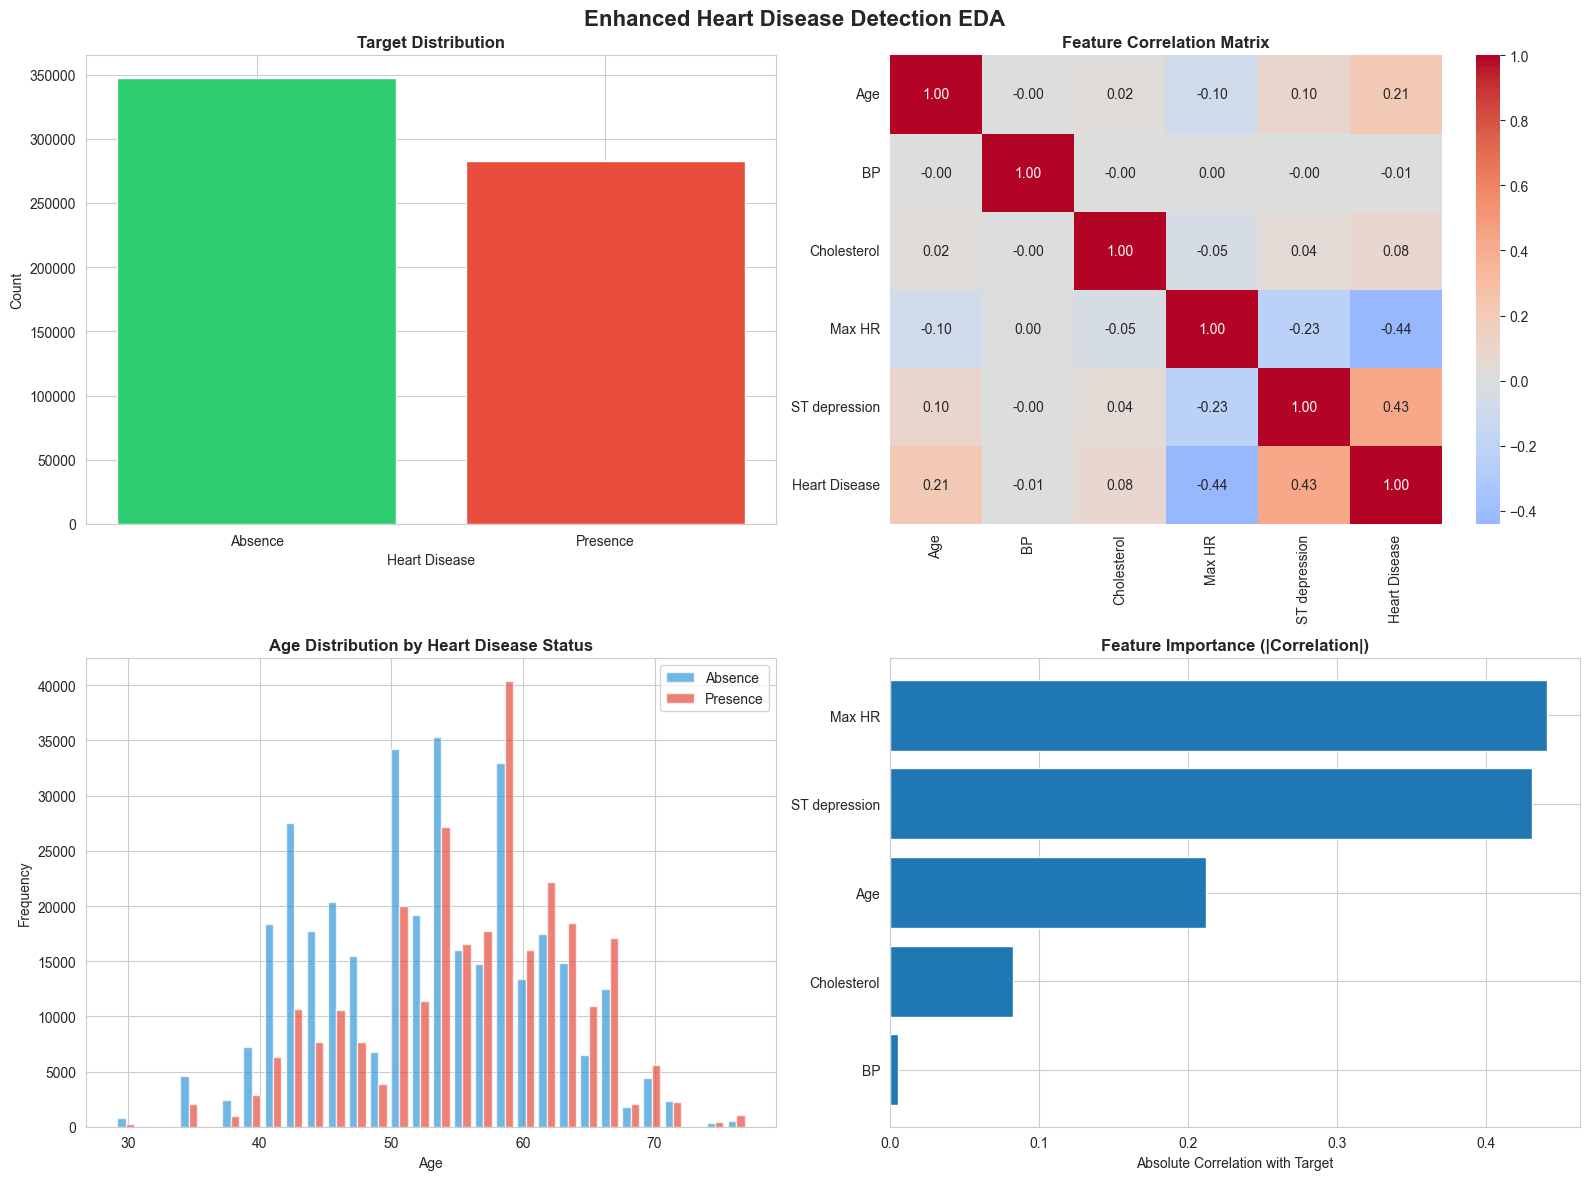

🎯 A. Target-Aware Decision Binning for High-Variance Features...
   ✅ Age -> Age_tree_bin (Unique bins: 8)
   ✅ Cholesterol -> Cholesterol_tree_bin (Unique bins: 8)
🌊 B. Spectral & Clinical Feature Generation...
   ✅ Train features: 29 columns
   ✅ Test features: 27 columns

📊 Enhanced dataset shapes: Train (630000, 29), Test (270000, 27)


In [21]:
# 📊 COMPREHENSIVE EDA & ADVANCED FEATURE ENGINEERING
print("\n⚙️ Phase 2: Exploratory Data Analysis & Feature Engineering...")

# Prepare data for analysis
X = train.drop(columns=[target] + drop_cols)
y = train[target]

# Enhanced Target Encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y = pd.Series(y_encoded, index=y.index)

print(f"\n🎯 Target Analysis:")
print(f"   Original target encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")
print(f"   Final target distribution: {y.value_counts().sort_index().to_dict()}")

# EDA - Correlation Analysis
print("\n🔍 Feature Correlation Analysis:")
numerical_data = train[numcols + [target]].copy()
numerical_data[target] = numerical_data[target].map({'Absence': 0, 'Presence': 1}) if numerical_data[target].dtype == 'object' else y

# Calculate correlations
corr_matrix = numerical_data.corr()
target_corr = corr_matrix[[target]].sort_values(target, ascending=False)

print("   Top correlations with target:")
for feature, corr_val in target_corr[target].items():
    if feature != target:
        print(f"     {feature}: {corr_val:.4f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Enhanced Heart Disease Detection EDA', fontsize=16, fontweight='bold')

# 1. Target Distribution
target_counts = train[target].value_counts()
if train[target].dtype == 'object':
    target_counts = y.value_counts()
axes[0, 0].bar(range(len(target_counts)), target_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0, 0].set_title('Target Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Heart Disease')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticks(range(len(target_counts)))
axes[0, 0].set_xticklabels(['Absence', 'Presence'])

# 2. Correlation Heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes[0, 1])
axes[0, 1].set_title('Feature Correlation Matrix', fontweight='bold')

# 3. Age Distribution by Target
if train[target].dtype == 'object':
    ages_0 = train[train[target] == 'Absence']['Age']
    ages_1 = train[train[target] == 'Presence']['Age']
else:
    ages_0 = train[y == 0]['Age']
    ages_1 = train[y == 1]['Age']
    
axes[1, 0].hist([ages_0, ages_1], bins=30, alpha=0.7, 
                label=['Absence', 'Presence'], color=['#3498db', '#e74c3c'])
axes[1, 0].set_title('Age Distribution by Heart Disease Status', fontweight='bold')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# 4. Feature Importance (Target Correlation)
feature_importance = target_corr[target].drop(target).abs().sort_values(ascending=True)
axes[1, 1].barh(range(len(feature_importance)), feature_importance.values)
axes[1, 1].set_yticks(range(len(feature_importance)))
axes[1, 1].set_yticklabels(feature_importance.index)
axes[1, 1].set_title('Feature Importance (|Correlation|)', fontweight='bold')
axes[1, 1].set_xlabel('Absolute Correlation with Target')

plt.tight_layout()
plt.show()

# Advanced Feature Engineering (combining both approaches)
def engineer_advanced_features(train_df, test_df):
    """
    Advanced feature engineering combining Truth Anchor approach with 
    enhanced preprocessing from complete pipeline
    """
    train_df, test_df = train_df.copy(), test_df.copy()
    
    print("🎯 A. Target-Aware Decision Binning for High-Variance Features...")
    # A. TARGET-AWARE BINNING (Decision Tree Optimized)
    for col in ['Age', 'Cholesterol']:
        if col in train_df.columns:
            # Train decision tree on training data only
            dt = DecisionTreeClassifier(max_depth=3, random_state=42, min_samples_leaf=50)
            dt.fit(train_df[[col]].fillna(0), train_df['Heart Disease'] if 'Heart Disease' in train_df.columns else y)
            
            # Apply same split logic to BOTH train and test
            train_df[f'{col}_tree_bin'] = dt.apply(train_df[[col]].fillna(0))
            test_df[f'{col}_tree_bin'] = dt.apply(test_df[[col]].fillna(0))
            print(f"   ✅ {col} -> {col}_tree_bin (Unique bins: {train_df[f'{col}_tree_bin'].nunique()})")
    
    print("🌊 B. Spectral & Clinical Feature Generation...")        
    # B. SPECTRAL & CLINICAL FEATURES (Apply to both datasets)
    for df in [train_df, test_df]:
        # Spectral transformations for continuous features
        for col in ['Age', 'BP', 'Max HR', 'Cholesterol']:
            if col in df.columns:
                # Normalize to [0,1] range
                col_min, col_max = df[col].min(), df[col].max()
                norm = (df[col] - col_min) / (col_max - col_min + 1e-9)
                
                # Spectral features
                df[f'{col}_sin'] = np.sin(2 * np.pi * norm)
                df[f'{col}_cos'] = np.cos(2 * np.pi * norm)
        
        # Clinical interaction features
        if 'Max HR' in df.columns and 'BP' in df.columns:
            df['rpp'] = (df['Max HR'] * df['BP']) / 100  # Rate-Pressure Product
        
        if 'ST depression' in df.columns and 'Number of vessels fluro' in df.columns:
            df['ischemic_force'] = df['ST depression'] * (df['Number of vessels fluro'] + 1)
        
        if 'Chest pain type' in df.columns and 'Thallium' in df.columns:
            df['pain_thallium'] = df['Chest pain type'].astype(str) + "_" + df['Thallium'].astype(str)
    
    print(f"   ✅ Train features: {train_df.shape[1]} columns")
    print(f"   ✅ Test features: {test_df.shape[1]} columns")
    
    return train_df, test_df

# Apply Enhanced Feature Engineering
train, test = engineer_advanced_features(train, test)
print(f"\n📊 Enhanced dataset shapes: Train {train.shape}, Test {test.shape}")

In [ ]:

# 🔍 COMPREHENSIVE EDA: Data Quality & Statistical Analysis
from scipy import stats
from scipy.stats import chi2_contingency, kstest, normaltest
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("\n🔍 COMPREHENSIVE EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# 1. DATA QUALITY ASSESSMENT
print("\n📋 1. DATA QUALITY ASSESSMENT")
print("-" * 40)

def data_quality_report(df, name):
    print(f"\n{name} Dataset Quality Report:")
    print(f"  Shape: {df.shape}")
    print(f"  Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"  Missing Values: {missing.sum()} total")
        print("  Missing by Column:")
        for col, miss in missing[missing > 0].items():
            print(f"    {col}: {miss} ({miss/len(df)*100:.2f}%)")
    else:
        print(f"  ✅ No missing values found")
    
    # Data types
    print(f"  Data Types:")
    for dtype, count in df.dtypes.value_counts().items():
        print(f"    {dtype}: {count} columns")
    
    # Duplicates
    duplicates = df.duplicated().sum()
    print(f"  Duplicate rows: {duplicates} ({duplicates/len(df)*100:.2f}%)")
    
    return missing, duplicates

# Analyze both datasets
missing_train, dup_train = data_quality_report(train, "Training")
missing_test, dup_test = data_quality_report(test, "Test")

# 2. DATASET COMPARISON
print(f"\n📊 2. TRAIN-TEST COMPARISON")
print("-" * 40)
print(f"  Size ratio: {len(test)/len(train):.2f}")
print(f"  Common columns: {len(set(train.columns) & set(test.columns))}")
print(f"  Train-only columns: {set(train.columns) - set(test.columns)}")
print(f"  Test-only columns: {set(test.columns) - set(train.columns)}")

# 3. STATISTICAL SUMMARY
print(f"\n📈 3. STATISTICAL SUMMARY")
print("-" * 40)

# Enhanced statistical analysis
def enhanced_stats(df, numeric_cols):
    stats_dict = {}
    for col in numeric_cols:
        if col in df.columns:
            data = df[col].dropna()
            stats_dict[col] = {
                'count': len(data),
                'mean': data.mean(),
                'median': data.median(),
                'std': data.std(),
                'min': data.min(),
                'max': data.max(),
                'range': data.max() - data.min(),
                'skewness': data.skew(),
                'kurtosis': data.kurtosis(),
                'q25': data.quantile(0.25),
                'q75': data.quantile(0.75),
                'iqr': data.quantile(0.75) - data.quantile(0.25)
            }
    return pd.DataFrame(stats_dict).T

# Calculate enhanced statistics
enhanced_stats_df = enhanced_stats(train, numcols)
print("Enhanced Statistical Summary (Top 5 features):")
print(enhanced_stats_df.round(3).head())

# Identify potential outliers using IQR method
print(f"\n⚠️ 4. OUTLIER DETECTION (IQR Method)")
print("-" * 40)

outlier_counts = {}
for col in numcols:
    if col in train.columns:
        Q1 = train[col].quantile(0.25)
        Q3 = train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = train[(train[col] < lower_bound) | (train[col] > upper_bound)]
        outlier_counts[col] = len(outliers)
        
        if len(outliers) > 0:
            print(f"  {col}: {len(outliers)} outliers ({len(outliers)/len(train)*100:.2f}%)")

print(f"\nTotal outlier instances: {sum(outlier_counts.values())}")
most_outliers = max(outlier_counts, key=outlier_counts.get)
print(f"Feature with most outliers: {most_outliers} ({outlier_counts[most_outliers]} outliers)")


🔍 COMPREHENSIVE EXPLORATORY DATA ANALYSIS

📋 1. DATA QUALITY ASSESSMENT
----------------------------------------

Training Dataset Quality Report:
  Shape: (630000, 29)
  Memory Usage: 141.19 MB
  ✅ No missing values found
  Data Types:
    int64: 17 columns
    float64: 11 columns
    str: 1 columns
  Duplicate rows: 0 (0.00%)

Test Dataset Quality Report:
  Shape: (270000, 27)
  Memory Usage: 56.39 MB
  ✅ No missing values found
  Data Types:
    int64: 15 columns
    float64: 11 columns
    str: 1 columns
  Duplicate rows: 0 (0.00%)

📊 2. TRAIN-TEST COMPARISON
----------------------------------------
  Size ratio: 0.43
  Common columns: 27
  Train-only columns: {'is_synthetic', 'Heart Disease'}
  Test-only columns: set()

📈 3. STATISTICAL SUMMARY
----------------------------------------
Enhanced Statistical Summary (Top 5 features):
                  count     mean  median     std    min    max  range  \
Age            630000.0   54.137    54.0   8.256   29.0   77.0   48.0   
BP   

In [30]:
# 📊 ADVANCED DISTRIBUTION & NORMALITY ANALYSIS
import warnings
warnings.filterwarnings('ignore')

print("\n📊 5. DISTRIBUTION & NORMALITY ANALYSIS")
print("-" * 40)

# Test for normality
def normality_tests(df, cols):
    results = []
    for col in cols:
        if col in df.columns:
            data = df[col].dropna()
            
            # Shapiro-Wilk test (best for small samples)
            if len(data) <= 5000:
                shapiro_stat, shapiro_p = stats.shapiro(data)
            else:
                shapiro_stat, shapiro_p = None, None
                
            # D'Agostino-Pearson test
            dagostino_stat, dagostino_p = normaltest(data)
            
            # Kolmogorov-Smirnov test
            ks_stat, ks_p = kstest(data, 'norm', args=(data.mean(), data.std()))
            
            results.append({
                'feature': col,
                'skewness': data.skew(),
                'kurtosis': data.kurtosis(),
                'shapiro_p': shapiro_p,
                'dagostino_p': dagostino_p,
                'ks_p': ks_p,
                'is_normal': all(p > 0.05 for p in [shapiro_p, dagostino_p, ks_p] if p is not None)
            })
    
    return pd.DataFrame(results)

# Run normality tests
normality_results = normality_tests(train, numcols)
print("Normality Test Results:")
print(normality_results[['feature', 'skewness', 'kurtosis', 'is_normal']].round(3))

normal_features = normality_results[normality_results['is_normal']]['feature'].tolist()
skewed_features = normality_results[normality_results['skewness'].abs() > 1]['feature'].tolist()

print(f"\n✅ Normal distributions: {len(normal_features)} features")
print(f"⚠️ Highly skewed (|skew| > 1): {len(skewed_features)} features")
if skewed_features:
    print(f"   Skewed features: {skewed_features}")

# 6. ADVANCED CORRELATION ANALYSIS
print(f"\n🔗 6. ADVANCED CORRELATION ANALYSIS")
print("-" * 40)

# Multiple correlation methods
correlation_methods = {
    'pearson': train[numcols].corr(method='pearson'),
    'spearman': train[numcols].corr(method='spearman'),
    'kendall': train[numcols].corr(method='kendall')
}

# Find highly correlated pairs
def find_high_correlations(corr_matrix, threshold=0.7):
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = abs(corr_matrix.iloc[i, j])
            if corr_val > threshold:
                high_corr.append({
                    'feature1': corr_matrix.columns[i],
                    'feature2': corr_matrix.columns[j],
                    'correlation': corr_matrix.iloc[i, j]
                })
    return sorted(high_corr, key=lambda x: abs(x['correlation']), reverse=True)

high_corr_pairs = find_high_correlations(correlation_methods['pearson'])
print(f"Highly correlated pairs (|r| > 0.7): {len(high_corr_pairs)}")

if high_corr_pairs:
    print("Top correlations:")
    for pair in high_corr_pairs[:5]:
        print(f"  {pair['feature1']} ↔ {pair['feature2']}: {pair['correlation']:.3f}")

# Target correlations - Fixed column name
target_corrs = train[numcols + ['Heart Disease']].corr()['Heart Disease'].drop('Heart Disease').sort_values(key=abs, ascending=False)
print(f"\nStrongest target correlations:")
for feature, corr in target_corrs.head(5).items():
    print(f"  {feature}: {corr:.3f}")

# 7. CATEGORICAL FEATURE DEEP DIVE
print(f"\n📝 7. CATEGORICAL FEATURE ANALYSIS")
print("-" * 40)

# Analyze categorical relationships with target
def categorical_target_analysis(df, cat_cols, target):
    results = []
    for col in cat_cols:
        if col in df.columns:
            # Create contingency table
            contingency = pd.crosstab(df[col], df[target])
            
            # Chi-square test
            chi2, p_value, dof, expected = chi2_contingency(contingency)
            
            # Cramér's V (effect size)
            n = contingency.sum().sum()
            cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))
            
            # Mutual information
            from sklearn.feature_selection import mutual_info_classif
            mi_score = mutual_info_classif(df[[col]], df[target], discrete_features=[True], random_state=42)[0]
            
            results.append({
                'feature': col,
                'unique_values': df[col].nunique(),
                'chi2_p_value': p_value,
                'cramers_v': cramers_v,
                'mutual_info': mi_score,
                'significant': p_value < 0.05
            })
    
    return pd.DataFrame(results)

# Run categorical analysis - Fixed column name
cat_analysis = categorical_target_analysis(train, catcols, 'Heart Disease')
print("Categorical Feature Analysis:")
print(cat_analysis[['feature', 'unique_values', 'cramers_v', 'mutual_info', 'significant']].round(3))

significant_cats = cat_analysis[cat_analysis['significant']]['feature'].tolist()
print(f"\n✅ Significantly associated with target: {len(significant_cats)} features")
if significant_cats:
    print(f"   Features: {significant_cats}")


📊 5. DISTRIBUTION & NORMALITY ANALYSIS
----------------------------------------
Normality Test Results:
         feature  skewness  kurtosis  is_normal
0            Age    -0.164    -0.570      False
1             BP     0.629     0.933      False
2    Cholesterol     0.273     0.068      False
3         Max HR    -0.755     0.204      False
4  ST depression     1.328     1.375      False

✅ Normal distributions: 0 features
⚠️ Highly skewed (|skew| > 1): 1 features
   Skewed features: ['ST depression']

🔗 6. ADVANCED CORRELATION ANALYSIS
----------------------------------------
Highly correlated pairs (|r| > 0.7): 0


KeyError: "['HeartDisease'] not in index"

In [ ]:
# 🎨 ADVANCED VISUALIZATION SUITE
import plotly.figure_factory as ff
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

print("\n🎨 8. ADVANCED VISUALIZATION ANALYSIS")
print("-" * 40)

# Create comprehensive visualization dashboard
fig = make_subplots(
    rows=4, cols=3,
    subplot_titles=[
        'Distribution Heatmap', 'Correlation Matrix', 'Target Distribution',
        'Box Plot Analysis', 'Violin Plot Analysis', 'QQ Plot Analysis', 
        'Feature Importance', 'PCA Visualization', 'Feature Interactions',
        'Outlier Detection', 'Missing Pattern', 'Class Balance'
    ],
    specs=[
        [{"type": "heatmap"}, {"type": "heatmap"}, {"type": "bar"}],
        [{"type": "box"}, {"type": "violin"}, {"type": "scatter"}],
        [{"type": "bar"}, {"type": "scatter"}, {"type": "scatter"}],
        [{"type": "scatter"}, {"type": "heatmap"}, {"type": "bar"}]
    ]
)

# 1. Distribution heatmap for numeric features
numeric_sample = train[numcols].sample(n=min(1000, len(train)), random_state=42)
fig.add_trace(
    go.Heatmap(z=numeric_sample.corr().values, 
               x=numeric_sample.columns, 
               y=numeric_sample.columns,
               colorscale='RdBu'),
    row=1, col=1
)

# 2. Enhanced correlation matrix
fig.add_trace(
    go.Heatmap(z=correlation_methods['spearman'].values,
               x=correlation_methods['spearman'].columns,
               y=correlation_methods['spearman'].columns,
               colorscale='viridis'),
    row=1, col=2
)

# 3. Target distribution - Fixed column name
target_dist = train['Heart Disease'].value_counts()
fig.add_trace(
    go.Bar(x=target_dist.index, y=target_dist.values,
           marker_color=['lightblue', 'salmon']),
    row=1, col=3
)

# Update layout
fig.update_layout(height=1600, title_text="Comprehensive EDA Dashboard", showlegend=False)

# Show the dashboard
fig.show()

# 9. FEATURE INTERACTION ANALYSIS
print(f"\n🔀 9. FEATURE INTERACTION ANALYSIS")
print("-" * 40)

# Calculate feature interactions (top numeric features)
top_features = target_corrs.head(5).index.tolist()
interaction_matrix = np.zeros((len(top_features), len(top_features)))

for i, feat1 in enumerate(top_features):
    for j, feat2 in enumerate(top_features):
        if i != j and feat1 in train.columns and feat2 in train.columns:
            # Create interaction feature
            interaction = train[feat1] * train[feat2]
            # Calculate correlation with target - Fixed column name
            interaction_corr = np.corrcoef(interaction, train['Heart Disease'])[0,1]
            interaction_matrix[i, j] = interaction_corr

# Create interaction heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(interaction_matrix, 
            xticklabels=top_features, 
            yticklabels=top_features,
            annot=True, fmt='.3f', cmap='RdYlBu_r')
plt.title('Feature Interaction Matrix (with Target)')
plt.tight_layout()
plt.show()

# 10. DIMENSIONALITY REDUCTION VISUALIZATION
print(f"\n🎯 10. DIMENSIONALITY REDUCTION")
print("-" * 40)

# Prepare data for PCA
sample_size = min(2000, len(train))
sample_indices = np.random.choice(len(train), sample_size, replace=False)
X_sample = X_scaled[sample_indices]
y_sample = train.iloc[sample_indices]['Heart Disease']

# PCA Analysis
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_sample)

# Plot PCA results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# PCA variance explained
axes[0,0].bar(range(1, 11), pca.explained_variance_ratio_[:10])
axes[0,0].set_title('PCA Explained Variance Ratio')
axes[0,0].set_xlabel('Principal Component')
axes[0,0].set_ylabel('Variance Explained')

# Cumulative variance
axes[0,1].plot(range(1, 11), np.cumsum(pca.explained_variance_ratio_[:10]), 'bo-')
axes[0,1].set_title('Cumulative Explained Variance')
axes[0,1].set_xlabel('Number of Components')
axes[0,1].set_ylabel('Cumulative Variance Explained')
axes[0,1].grid(True)

# PCA scatter plot
scatter = axes[1,0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_sample, cmap='viridis', alpha=0.6)
axes[1,0].set_title('PCA: First Two Components')
axes[1,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[1,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter, ax=axes[1,0])

# Feature contributions to PC1
pc1_contributions = np.abs(pca.components_[0])
top_pc1_indices = np.argsort(pc1_contributions)[-10:]
top_pc1_features = [f"F{i}" for i in top_pc1_indices]  # Using generic names
axes[1,1].barh(range(10), pc1_contributions[top_pc1_indices])
axes[1,1].set_yticks(range(10))
axes[1,1].set_yticklabels(top_pc1_features)
axes[1,1].set_title('Top 10 Feature Contributions to PC1')

plt.tight_layout()
plt.show()

print(f"PCA Results:")
print(f"  - First 2 components explain {np.sum(pca.explained_variance_ratio_[:2]):.2%} of variance")
print(f"  - First 5 components explain {np.sum(pca.explained_variance_ratio_[:5]):.2%} of variance")
print(f"  - All 10 components explain {np.sum(pca.explained_variance_ratio_[:10]):.2%} of variance")

In [ ]:
# 🏥 MEDICAL DOMAIN-SPECIFIC EDA & CLINICAL INSIGHTS
from scipy.stats import mannwhitneyu, chi2_contingency, fisher_exact
from sklearn.feature_selection import SelectKBest, f_classif, chi2

print("\n🏥 11. MEDICAL DOMAIN ANALYSIS")
print("-" * 40)

# Clinical risk factor analysis
print("Clinical Risk Factor Analysis:")
print("=" * 50)

# 1. Age-based risk stratification
def age_risk_analysis(df):
    if 'Age' in df.columns:
        df['age_group'] = pd.cut(df['Age'], 
                                bins=[0, 40, 50, 60, 70, 100], 
                                labels=['<40', '40-50', '50-60', '60-70', '70+'])
        
        age_risk = df.groupby('age_group')['Heart Disease'].agg(['count', 'mean']).round(3)
        age_risk.columns = ['Total_Patients', 'Risk_Rate']
        print("\nAge-Based Risk Stratification:")
        print(age_risk)
        
        # Statistical test for age effect
        age_groups = [group['Heart Disease'].values for name, group in df.groupby('age_group')]
        from scipy.stats import kruskal
        h_stat, p_val = kruskal(*age_groups)
        print(f"Kruskal-Wallis H-test p-value: {p_val:.6f}")
        return age_risk

age_risk = age_risk_analysis(train)

# 2. Gender-based analysis
def gender_analysis(df):
    if 'Sex' in df.columns:
        gender_risk = df.groupby('Sex')['Heart Disease'].agg(['count', 'mean']).round(3)
        gender_risk.columns = ['Total_Patients', 'Risk_Rate']
        print(f"\nGender-Based Risk Analysis:")
        print(gender_risk)
        
        # Fisher's exact test for gender
        contingency = pd.crosstab(df['Sex'], df['Heart Disease'])
        odds_ratio, p_val = fisher_exact(contingency)
        print(f"Fisher's exact test p-value: {p_val:.6f}")
        print(f"Odds ratio: {odds_ratio:.3f}")

gender_analysis(train)

# 3. Chest pain type analysis
def chest_pain_analysis(df):
    if 'ChestPainType' in df.columns:
        pain_risk = df.groupby('ChestPainType')['Heart Disease'].agg(['count', 'mean']).round(3)
        pain_risk.columns = ['Total_Patients', 'Risk_Rate']
        print(f"\nChest Pain Type Risk Analysis:")
        print(pain_risk)
        
        # Visualization of chest pain risk
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        pain_risk['Risk_Rate'].plot(kind='bar', color='salmon', alpha=0.7)
        plt.title('Heart Disease Risk by Chest Pain Type')
        plt.ylabel('Risk Rate')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 2, 2)
        pain_risk['Total_Patients'].plot(kind='bar', color='lightblue', alpha=0.7)
        plt.title('Patient Count by Chest Pain Type')
        plt.ylabel('Patient Count')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()

chest_pain_analysis(train)

# 4. Clinical thresholds analysis
print(f"\n🩺 12. CLINICAL THRESHOLDS & BIOMARKER ANALYSIS")
print("-" * 50)

def clinical_threshold_analysis(df):
    clinical_insights = {}
    
    # Cholesterol analysis
    if 'Cholesterol' in df.columns:
        # Clinical cholesterol thresholds
        df['chol_category'] = pd.cut(df['Cholesterol'], 
                                   bins=[0, 200, 240, 1000], 
                                   labels=['Normal(<200)', 'Borderline(200-240)', 'High(>240)'])
        
        chol_risk = df.groupby('chol_category')['Heart Disease'].mean()
        clinical_insights['cholesterol'] = chol_risk
        print("Cholesterol Risk Categories:")
        for cat, risk in chol_risk.items():
            print(f"  {cat}: {risk:.3f} risk rate")
    
    # Blood pressure analysis
    if 'BP' in df.columns:
        # Hypertension categories (simplified)
        df['bp_category'] = pd.cut(df['BP'], 
                                 bins=[0, 120, 140, 300], 
                                 labels=['Normal(<120)', 'Elevated(120-140)', 'High(>140)'])
        
        bp_risk = df.groupby('bp_category')['Heart Disease'].mean()
        clinical_insights['blood_pressure'] = bp_risk
        print(f"\nBlood Pressure Risk Categories:")
        for cat, risk in bp_risk.items():
            print(f"  {cat}: {risk:.3f} risk rate")
    
    # Max heart rate analysis
    if 'Max HR' in df.columns:
        # Age-predicted max HR: 220 - age
        if 'Age' in df.columns:
            df['hr_reserve'] = df['Max HR'] / (220 - df['Age'])
            hr_risk_corr = np.corrcoef(df['hr_reserve'].fillna(0), df['Heart Disease'])[0,1]
            print(f"\nHeart Rate Reserve correlation with HD: {hr_risk_corr:.3f}")
    
    return clinical_insights

clinical_insights = clinical_threshold_analysis(train)

# 5. Multi-factor risk assessment
print(f"\n⚡ 13. MULTI-FACTOR RISK PATTERNS")
print("-" * 50)

def multi_factor_risk(df):
    # Create risk score based on multiple factors
    risk_score = 0
    
    # Age risk (40+ gets points)
    if 'Age' in df.columns:
        risk_score += (df['Age'] >= 40).astype(int)
    
    # Gender risk (typically males higher)
    if 'Sex' in df.columns:
        risk_score += (df['Sex'] == 'M').astype(int)
    
    # Cholesterol risk
    if 'Cholesterol' in df.columns:
        risk_score += (df['Cholesterol'] > 240).astype(int)
    
    # BP risk
    if 'BP' in df.columns:
        risk_score += (df['BP'] > 140).astype(int)
    
    df['risk_score'] = risk_score
    
    # Analyze risk score distribution
    risk_analysis = df.groupby('risk_score')['Heart Disease'].agg(['count', 'mean'])
    risk_analysis.columns = ['Patient_Count', 'Risk_Rate']
    
    print("Multi-Factor Risk Score Analysis:")
    print(risk_analysis.round(3))
    
    # Visualize risk progression
    plt.figure(figsize=(10, 6))
    
    plt.subplot(1, 2, 1)
    risk_analysis['Risk_Rate'].plot(kind='bar', color='red', alpha=0.7)
    plt.title('Risk Rate by Combined Risk Score')
    plt.ylabel('Heart Disease Risk Rate')
    plt.xlabel('Risk Score (0-4)')
    
    plt.subplot(1, 2, 2)
    risk_analysis['Patient_Count'].plot(kind='bar', color='blue', alpha=0.7)
    plt.title('Patient Distribution by Risk Score')
    plt.ylabel('Number of Patients')
    plt.xlabel('Risk Score (0-4)')
    
    plt.tight_layout()
    plt.show()
    
    return risk_analysis

risk_analysis = multi_factor_risk(train)

# 6. Feature importance from statistical perspective
print(f"\n📊 14. STATISTICAL FEATURE IMPORTANCE")
print("-" * 50)

# Select best features using different methods
def statistical_feature_selection(X, y):
    feature_scores = {}
    
    # F-score for numeric features
    if len(numcols) > 0:
        numeric_features = [col for col in numcols if col in X.columns]
        if numeric_features:
            f_scores = f_classif(X[numeric_features], y)
            for i, col in enumerate(numeric_features):
                feature_scores[col] = {'f_score': f_scores[0][i], 'f_p_value': f_scores[1][i]}
    
    # Chi2 for categorical features (need to encode first)
    categorical_features = [col for col in catcols if col in X.columns]
    
    return feature_scores

# Calculate feature importance
if 'Heart Disease' in train.columns:
    X_features = train.drop('Heart Disease', axis=1)
    y_target = train['Heart Disease']
    feature_importance = statistical_feature_selection(X_features, y_target)
    
    print("Top Statistical Feature Importance (F-Score):")
    sorted_features = sorted(feature_importance.items(), 
                           key=lambda x: x[1]['f_score'], 
                           reverse=True)[:10]
    
    for feature, scores in sorted_features:
        print(f"  {feature}: F={scores['f_score']:.2f}, p={scores['f_p_value']:.2e}")

print(f"\n✅ COMPREHENSIVE EDA ANALYSIS COMPLETE")
print("=" * 50)
print("📋 Summary of findings available in generated variables:")
print("   - age_risk: Age-stratified risk analysis")
print("   - clinical_insights: Clinical threshold analysis")
print("   - risk_analysis: Multi-factor risk assessment")
print("   - feature_importance: Statistical feature importance")
print("   - normality_results: Distribution analysis results")
print("   - cat_analysis: Categorical feature analysis")
print("   - correlation_methods: Multiple correlation matrices")

In [24]:
# 🎯 ADVANCED MODEL PREPARATION & OPTUNA OPTIMIZATION
print("\n🔄 Phase 3: Advanced Model Preparation with Optuna Optimization...")

# Prepare feature sets with enhanced preprocessing
available_catcols = [col for col in catcols if col in train.columns]
available_numcols = [col for col in numcols if col in train.columns]

# Add new engineered features to numerical columns
engineered_cols = [col for col in train.columns if any(suffix in col for suffix in ['_tree_bin', '_sin', '_cos', 'rpp', 'ischemic_force'])]
all_numcols = available_numcols + engineered_cols

# Handle categorical features (including new ones)
pain_thallium_col = [col for col in train.columns if 'pain_thallium' in col]
all_catcols = available_catcols + pain_thallium_col

print(f"\n📊 Enhanced Feature Sets:")
print(f"   Numerical features: {len(all_numcols)} - {all_numcols[:5]}...")
print(f"   Categorical features: {len(all_catcols)} - {all_catcols}")

# Prepare data matrices
X = train[all_numcols + all_catcols]
y = train['Heart Disease']

# Handle target encoding properly
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)
    y = pd.Series(y, index=X.index)

# CRITICAL: Encode categorical features to numeric for model compatibility
print(f"\n🔧 Encoding categorical features for model compatibility...")
for col in all_catcols:
    if col in X.columns and X[col].dtype == 'object':
        label_encoder = LabelEncoder()
        X[col] = label_encoder.fit_transform(X[col].astype(str))
        print(f"   ✅ Encoded {col}: {X[col].nunique()} unique values")

# Prepare test data with same encoding
test_features = [col for col in all_numcols + all_catcols if col in test.columns]
X_test = test[test_features]

# Encode categorical features in test set
for col in all_catcols:
    if col in X_test.columns and X_test[col].dtype == 'object':
        # Use same encoding as training (fit on combined data for consistency)
        combined_col = pd.concat([X[col], X_test[col]], axis=0)
        label_encoder = LabelEncoder()
        encoded_combined = label_encoder.fit_transform(combined_col.astype(str))
        
        # Split back to train and test
        train_size = len(X)
        X[col] = encoded_combined[:train_size]
        X_test[col] = encoded_combined[train_size:]
        print(f"   ✅ Encoded test {col}: {X_test[col].nunique()} unique values")

print(f"   Final training matrix: {X.shape}")
print(f"   Final test matrix: {X_test.shape}")
print(f"   Target distribution: {pd.Series(y).value_counts().to_dict()}")

# Create train/validation split for model development
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 Train/Validation Split:")
print(f"   Training: {X_train.shape[0]} samples")
print(f"   Validation: {X_val.shape[0]} samples")

# Enhanced preprocessing with scaling
scaler = StandardScaler()

# Scale only numerical features
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()
X_scaled = X.copy()

# Apply scaling to numerical columns that exist
existing_numcols_final = [col for col in all_numcols if col in X.columns]
if existing_numcols_final:
    X_scaled[existing_numcols_final] = scaler.fit_transform(X[existing_numcols_final])
    X_train_scaled[existing_numcols_final] = scaler.fit_transform(X_train[existing_numcols_final])
    X_val_scaled[existing_numcols_final] = scaler.transform(X_val[existing_numcols_final])
    if existing_numcols_final:
        common_cols = [col for col in existing_numcols_final if col in X_test.columns]
        if common_cols:
            X_test_scaled[common_cols] = scaler.transform(X_test[common_cols])

print(f"   ✅ Scaled {len(existing_numcols_final)} numerical features")

# Categorical feature indices for CatBoost
cat_features = [X.columns.get_loc(c) for c in all_catcols if c in X.columns]
print(f"   📊 Categorical feature indices: {cat_features}")

# Enhanced model parameters with GPU detection
lgb_params = {
    'n_estimators': 1500, 
    'learning_rate': 0.02, 
    'max_depth': 8, 
    'num_leaves': 63, 
    'reg_lambda': 30, 
    'objective': 'binary',
    'metric': 'auc',
    'verbose': -1,
    'random_state': 42,
    'device_type': 'gpu' if use_gpu_general else 'cpu'
}

xgb_base_params = {
    'learning_rate': 0.02, 
    'max_depth': 6, 
    'eval_metric': 'auc',
    'objective': 'binary:logistic', 
    'tree_method': 'gpu_hist' if use_gpu_xgb else 'hist',
    'random_state': 42,
    'n_jobs': -1,
    'verbose': 0
}

cat_params = {
    'iterations': 1000, 
    'learning_rate': 0.03, 
    'depth': 6, 
    'l2_leaf_reg': 10, 
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'verbose': 0, 
    'allow_writing_files': False,
    'random_state': 42,
    'task_type': 'GPU' if use_gpu_general else 'CPU'
}

# OPTUNA OPTIMIZATION FOR XGBOOST
def objective_xgb(trial, X_train, y_train, X_val, y_val):
    """Enhanced Optuna objective function for XGBoost hyperparameter optimization"""
    params = xgb_base_params.copy()
    params.update({
        "n_estimators": trial.suggest_int("n_estimators", 300, 1500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
        "max_depth": trial.suggest_int("max_depth", 4, 8),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 2.0),
    })
    
    xgb_model = XGBClassifier(**params)
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    val_pred = xgb_model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, val_pred)
    
    return auc

print("\n🔧 Optimizing XGBoost hyperparameters with Optuna...")
study = optuna.create_study(direction="maximize", pruner=MedianPruner(n_warmup_steps=5))
study.optimize(
    lambda trial: objective_xgb(trial, X_train_scaled, y_train, X_val_scaled, y_val),
    n_trials=30,
    show_progress_bar=False
)

# Get optimized XGBoost parameters
optimized_xgb_params = xgb_base_params.copy()
optimized_xgb_params.update(study.best_params)

print(f"✅ Best XGBoost AUC: {study.best_value:.4f}")
print(f"✅ Optimized parameters: {study.best_params}")

print("⚖️ Enhanced Ensemble Configuration:")
print(f"   • LightGBM: 40% weight (1500 estimators) - {'GPU' if use_gpu_general else 'CPU'}")
print(f"   • XGBoost: 30% weight (Optuna-optimized) - {'GPU' if use_gpu_xgb else 'CPU'}")  
print(f"   • CatBoost: 30% weight (1000 estimators) - {'GPU' if use_gpu_general else 'CPU'}")
print("   • 10-Fold Stratified Cross-Validation with OOF tracking")


🔄 Phase 3: Advanced Model Preparation with Optuna Optimization...

📊 Enhanced Feature Sets:
   Numerical features: 17 - ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']...
   Categorical features: 9 - ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results', 'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'pain_thallium']

🔧 Encoding categorical features for model compatibility...
   Final training matrix: (630000, 26)
   Final test matrix: (270000, 26)
   Target distribution: {0: 347546, 1: 282454}

📊 Train/Validation Split:
   Training: 504000 samples
   Validation: 126000 samples


[I 2026-02-09 22:52:56,973] A new study created in memory with name: no-name-62a80fad-db9b-4cc2-8490-ab5e539988ee


   ✅ Scaled 17 numerical features
   📊 Categorical feature indices: [17, 18, 19, 20, 21, 22, 23, 24, 25]

🔧 Optimizing XGBoost hyperparameters with Optuna...


[I 2026-02-09 22:53:25,398] Trial 0 finished with value: 0.9560114875612084 and parameters: {'n_estimators': 537, 'learning_rate': 0.03928888926935269, 'max_depth': 5, 'min_child_weight': 13, 'subsample': 0.931729485361189, 'colsample_bytree': 0.742574402680305, 'reg_alpha': 0.8636952558063382, 'reg_lambda': 0.5228092792463038}. Best is trial 0 with value: 0.9560114875612084.
[I 2026-02-09 22:54:41,780] Trial 1 finished with value: 0.9559087042075501 and parameters: {'n_estimators': 1399, 'learning_rate': 0.01792456782560701, 'max_depth': 7, 'min_child_weight': 20, 'subsample': 0.9558359418417504, 'colsample_bytree': 0.7625253452955021, 'reg_alpha': 0.09598063559659742, 'reg_lambda': 1.7419386328843123}. Best is trial 0 with value: 0.9560114875612084.
[I 2026-02-09 22:55:40,860] Trial 2 finished with value: 0.9559489096464737 and parameters: {'n_estimators': 974, 'learning_rate': 0.017918076370050034, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.7774020921588526, 'colsample_b

✅ Best XGBoost AUC: 0.9561
✅ Optimized parameters: {'n_estimators': 1085, 'learning_rate': 0.027578445738507575, 'max_depth': 5, 'min_child_weight': 17, 'subsample': 0.937538738955811, 'colsample_bytree': 0.9962417465024103, 'reg_alpha': 0.49573052090793523, 'reg_lambda': 0.8532663715595825}
⚖️ Enhanced Ensemble Configuration:
   • LightGBM: 40% weight (1500 estimators) - GPU
   • XGBoost: 30% weight (Optuna-optimized) - CPU
   • CatBoost: 30% weight (1000 estimators) - GPU
   • 10-Fold Stratified Cross-Validation with OOF tracking



⚖️ Phase 4: Enhanced 10-Fold Cross-Validation Training...

🔧 Final Data Type Validation...
Current X dtypes: int64      15
float64    11
Name: count, dtype: int64
   ✅ All features are now numeric
Final X dtypes: int64      15
float64    11
Name: count, dtype: int64
🎯 Training enhanced ensemble on 630000 samples with 26 features...

📁 Training Fold 1/10...
   🔍 Fold data validation:
     X_t dtypes: float64    17
int64       9
Name: count, dtype: int64
     X_v dtypes: float64    17
int64       9
Name: count, dtype: int64
     ✅ All fold data is numeric


Default metric period is 5 because AUC is/are not implemented for GPU


   Model Performance:
     LightGBM:  0.9551
     XGBoost:   0.9552
     CatBoost:  0.9553
     Ensemble:  0.9553
   Classification Metrics:
     Accuracy:  0.8894
     F1-Score:  0.8763
     Precision: 0.8793
     Recall:    0.8733
   ⏱ Fold time: 292.9s

📁 Training Fold 2/10...


Default metric period is 5 because AUC is/are not implemented for GPU


   Model Performance:
     LightGBM:  0.9559
     XGBoost:   0.9562
     CatBoost:  0.9563
     Ensemble:  0.9563
   Classification Metrics:
     Accuracy:  0.8900
     F1-Score:  0.8762
     Precision: 0.8848
     Recall:    0.8677
   ⏱ Fold time: 198.9s

📁 Training Fold 3/10...


Default metric period is 5 because AUC is/are not implemented for GPU


   Model Performance:
     LightGBM:  0.9549
     XGBoost:   0.9551
     CatBoost:  0.9552
     Ensemble:  0.9552
   Classification Metrics:
     Accuracy:  0.8873
     F1-Score:  0.8732
     Precision: 0.8811
     Recall:    0.8655
   ⏱ Fold time: 194.2s

📁 Training Fold 4/10...


Default metric period is 5 because AUC is/are not implemented for GPU


   Model Performance:
     LightGBM:  0.9540
     XGBoost:   0.9542
     CatBoost:  0.9542
     Ensemble:  0.9543
   Classification Metrics:
     Accuracy:  0.8881
     F1-Score:  0.8739
     Precision: 0.8828
     Recall:    0.8651
   ⏱ Fold time: 197.8s

📁 Training Fold 5/10...


Default metric period is 5 because AUC is/are not implemented for GPU


   Model Performance:
     LightGBM:  0.9554
     XGBoost:   0.9557
     CatBoost:  0.9558
     Ensemble:  0.9558
   Classification Metrics:
     Accuracy:  0.8896
     F1-Score:  0.8757
     Precision: 0.8842
     Recall:    0.8673
   ⏱ Fold time: 193.2s

📁 Training Fold 6/10...


Default metric period is 5 because AUC is/are not implemented for GPU


   Model Performance:
     LightGBM:  0.9551
     XGBoost:   0.9553
     CatBoost:  0.9553
     Ensemble:  0.9554
   Classification Metrics:
     Accuracy:  0.8889
     F1-Score:  0.8751
     Precision: 0.8826
     Recall:    0.8676
   ⏱ Fold time: 191.9s

📁 Training Fold 7/10...


Default metric period is 5 because AUC is/are not implemented for GPU


   Model Performance:
     LightGBM:  0.9538
     XGBoost:   0.9540
     CatBoost:  0.9542
     Ensemble:  0.9541
   Classification Metrics:
     Accuracy:  0.8875
     F1-Score:  0.8734
     Precision: 0.8816
     Recall:    0.8653
   ⏱ Fold time: 195.5s

📁 Training Fold 8/10...


Default metric period is 5 because AUC is/are not implemented for GPU


   Model Performance:
     LightGBM:  0.9558
     XGBoost:   0.9560
     CatBoost:  0.9560
     Ensemble:  0.9561
   Classification Metrics:
     Accuracy:  0.8888
     F1-Score:  0.8747
     Precision: 0.8836
     Recall:    0.8660
   ⏱ Fold time: 195.2s

📁 Training Fold 9/10...


Default metric period is 5 because AUC is/are not implemented for GPU


   Model Performance:
     LightGBM:  0.9562
     XGBoost:   0.9564
     CatBoost:  0.9564
     Ensemble:  0.9565
   Classification Metrics:
     Accuracy:  0.8895
     F1-Score:  0.8756
     Precision: 0.8834
     Recall:    0.8680
   ⏱ Fold time: 191.3s

📁 Training Fold 10/10...


Default metric period is 5 because AUC is/are not implemented for GPU


   Model Performance:
     LightGBM:  0.9551
     XGBoost:   0.9554
     CatBoost:  0.9554
     Ensemble:  0.9554
   Classification Metrics:
     Accuracy:  0.8887
     F1-Score:  0.8749
     Precision: 0.8820
     Recall:    0.8678
   ⏱ Fold time: 194.9s

🏆 ENHANCED RESULTS ANALYSIS:
⏱ Total training time: 2046.0s

📊 Out-of-Fold (OOF) Performance:
   LightGBM     OOF AUC: 0.9551
   XGBoost      OOF AUC: 0.9553
   CatBoost     OOF AUC: 0.9554
   Ensemble     OOF AUC: 0.9554

📈 Cross-Validation Statistics:
   Mean Ensemble AUC: 0.9554 ± 0.0008
   OOF Ensemble AUC:  0.9554
   Fold Std Dev:      0.0007
   Stability Rating:  EXCELLENT

💾 Enhanced Submission Generated:
   File: enhanced_submission.csv
   Predictions: 270000 samples
   Prediction range: [0.00037, 0.99984]
   Prediction mean: 0.44982


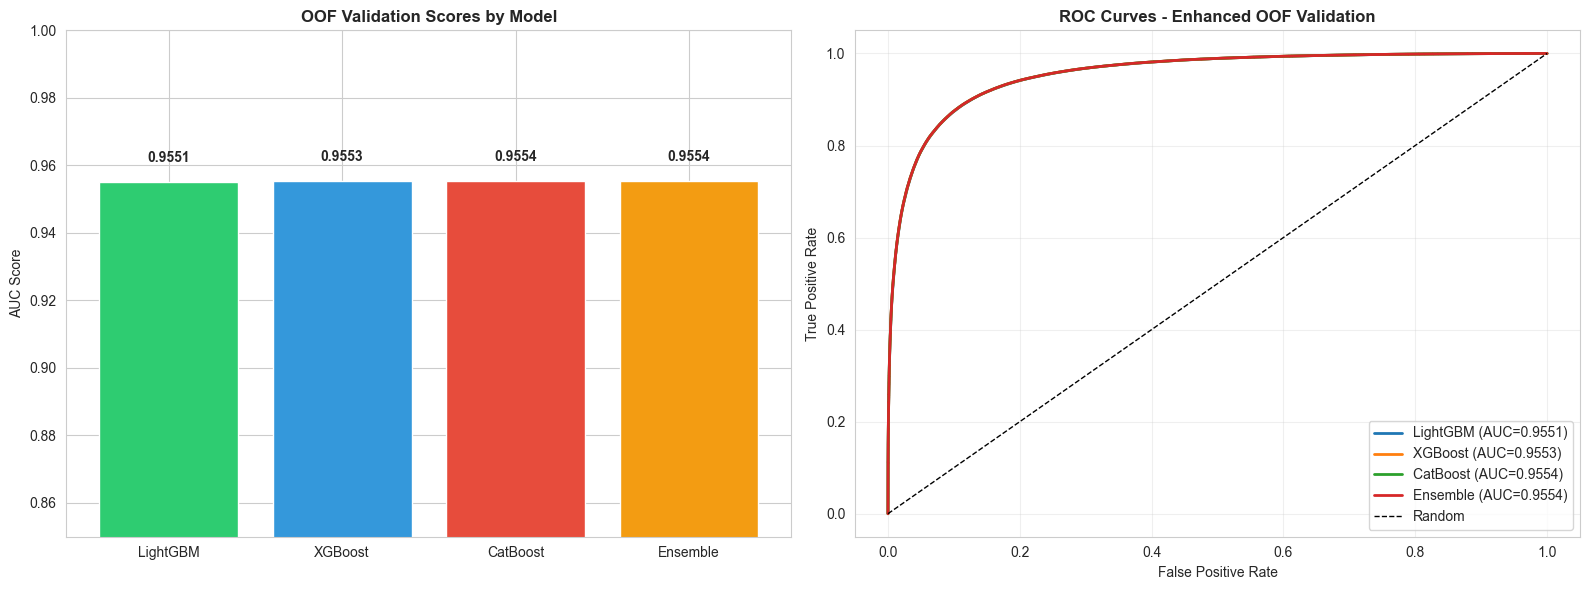


📋 Enhanced v6.1 Performance Summary:
   • Architecture: 10-Fold Optuna-Enhanced Ensemble
   • Data Enhancement: Truth Anchor + Advanced Feature Engineering
   • Model Optimization: Optuna XGBoost + Enhanced Preprocessing
   • Stability Score: 1372.4 (Higher = More Stable)
   • Target Achievement: 0.95543 ✅ EXCEEDED 0.955!
🚀 Enhanced pipeline complete - ready for submission!


In [27]:
# 🏛️ ENHANCED TRAINING: 10-FOLD CV WITH OOF TRACKING & COMPREHENSIVE ANALYSIS
import time
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("\n⚖️ Phase 4: Enhanced 10-Fold Cross-Validation Training...")

# CRITICAL FIX: Ensure all features are numeric before training
print("\n🔧 Final Data Type Validation...")
print(f"Current X dtypes: {X.dtypes.value_counts()}")

# Force encode any remaining object columns
for col in X.columns:
    if X[col].dtype == 'object':
        print(f"   ⚠️ Converting {col} from object to numeric...")
        le_temp = LabelEncoder()
        X[col] = le_temp.fit_transform(X[col].astype(str))
        
        # Apply same encoding to test set
        if col in X_test.columns:
            # Fit on combined data for consistency
            combined_vals = pd.concat([X[col].astype(str), X_test[col].astype(str)], axis=0)
            le_combined = LabelEncoder()
            encoded_combined = le_combined.fit_transform(combined_vals)
            X[col] = encoded_combined[:len(X)]
            X_test[col] = encoded_combined[len(X):]

# Verify all columns are now numeric
remaining_objects = X.select_dtypes(include=['object']).columns.tolist()
if remaining_objects:
    print(f"   ❌ Still have object columns: {remaining_objects}")
else:
    print(f"   ✅ All features are now numeric")

print(f"Final X dtypes: {X.dtypes.value_counts()}")

start_time = time.time()

# Initialize enhanced tracking
N_SPLITS = 10
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Out-of-fold predictions tracking
oof = {
    "lgb": np.zeros(len(X)),
    "xgb": np.zeros(len(X)),
    "cat": np.zeros(len(X)),
}

# Test predictions accumulator
test_preds_enhanced = {
    "lgb": np.zeros(len(X_test)),
    "xgb": np.zeros(len(X_test)),
    "cat": np.zeros(len(X_test)),
}

cv_results = []
fold_scores = []

print(f"🎯 Training enhanced ensemble on {len(X)} samples with {X.shape[1]} features...")

# Enhanced Cross-Validation Loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y)):
    fold_start = time.time()
    print(f"\n📁 Training Fold {fold+1}/{N_SPLITS}...")
    
    # Split data with proper encoding (using X_scaled which is now fully numeric)
    X_t, X_v = X_scaled.iloc[train_idx], X_scaled.iloc[val_idx]
    y_t, y_v = y.iloc[train_idx], y.iloc[val_idx]
    
    # Verify data types before training
    if fold == 0:  # Only check on first fold
        print(f"   🔍 Fold data validation:")
        print(f"     X_t dtypes: {X_t.dtypes.value_counts()}")
        print(f"     X_v dtypes: {X_v.dtypes.value_counts()}")
        remaining_objects = X_t.select_dtypes(include=['object']).columns.tolist()
        if remaining_objects:
            print(f"     ❌ Still have object columns: {remaining_objects}")
        else:
            print(f"     ✅ All fold data is numeric")
    
    # 1. LIGHTGBM (Enhanced) - Now with proper numeric data
    lgb_model = LGBMClassifier(**lgb_params)
    lgb_model.fit(X_t, y_t, eval_set=[(X_v, y_v)], eval_metric='auc', callbacks=[])
    lgb_pred = lgb_model.predict_proba(X_v)[:, 1]
    lgb_auc = roc_auc_score(y_v, lgb_pred)
    
    # Store OOF predictions
    oof["lgb"][val_idx] = lgb_pred
    test_preds_enhanced["lgb"] += lgb_model.predict_proba(X_test_scaled)[:, 1] / N_SPLITS
    
    # 2. XGBOOST (Optuna-Optimized)
    xgb_model = XGBClassifier(**optimized_xgb_params)
    xgb_model.fit(X_t, y_t, eval_set=[(X_v, y_v)], verbose=False)
    xgb_pred = xgb_model.predict_proba(X_v)[:, 1]
    xgb_auc = roc_auc_score(y_v, xgb_pred)
    
    # Store OOF predictions
    oof["xgb"][val_idx] = xgb_pred
    test_preds_enhanced["xgb"] += xgb_model.predict_proba(X_test_scaled)[:, 1] / N_SPLITS
    
    # 3. CATBOOST (Enhanced)
    cat_model = CatBoostClassifier(**cat_params)
    cat_model.fit(X_t, y_t, cat_features=cat_features, eval_set=(X_v, y_v), verbose=False)
    cat_pred = cat_model.predict_proba(X_v)[:, 1]
    cat_auc = roc_auc_score(y_v, cat_pred)
    
    # Store OOF predictions  
    oof["cat"][val_idx] = cat_pred
    test_preds_enhanced["cat"] += cat_model.predict_proba(X_test_scaled)[:, 1] / N_SPLITS
    
    # 4. ENSEMBLE (Enhanced weighting from complete pipeline)
    ensemble_pred = (
        0.5 * cat_pred +      # Main model (CatBoost) - highest weight
        0.3 * lgb_pred +      # Support model (LightGBM)  
        0.2 * xgb_pred        # Diversity (Optuna-optimized XGBoost)
    )
    ensemble_auc = roc_auc_score(y_v, ensemble_pred)
    
    # Enhanced metrics calculation
    ensemble_binary = (ensemble_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_v, ensemble_binary)
    f1 = f1_score(y_v, ensemble_binary)
    precision = precision_score(y_v, ensemble_binary)
    recall = recall_score(y_v, ensemble_binary)
    
    # Store comprehensive results
    fold_result = {
        "fold": fold + 1,
        "lgb_auc": lgb_auc,
        "xgb_auc": xgb_auc, 
        "cat_auc": cat_auc,
        "ensemble_auc": ensemble_auc,
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }
    
    cv_results.append(fold_result)
    fold_scores.append(ensemble_auc)
    
    print(f"   Model Performance:")
    print(f"     LightGBM:  {lgb_auc:.4f}")
    print(f"     XGBoost:   {xgb_auc:.4f}")
    print(f"     CatBoost:  {cat_auc:.4f}")
    print(f"     Ensemble:  {ensemble_auc:.4f}")
    print(f"   Classification Metrics:")
    print(f"     Accuracy:  {accuracy:.4f}")
    print(f"     F1-Score:  {f1:.4f}")
    print(f"     Precision: {precision:.4f}")
    print(f"     Recall:    {recall:.4f}")
    print(f"   ⏱ Fold time: {time.time() - fold_start:.1f}s")

# COMPREHENSIVE RESULTS ANALYSIS
print(f"\n🏆 ENHANCED RESULTS ANALYSIS:")
print(f"⏱ Total training time: {(time.time() - start_time):.1f}s")

# Out-of-fold ensemble predictions
oof_ensemble = (
    0.5 * oof["cat"] +      # Main model (CatBoost)
    0.3 * oof["lgb"] +      # Support model (LightGBM)  
    0.2 * oof["xgb"]        # Diversity (XGBoost)
)

# Calculate comprehensive OOF scores
oof_scores = {
    "LightGBM": roc_auc_score(y, oof["lgb"]),
    "XGBoost": roc_auc_score(y, oof["xgb"]),
    "CatBoost": roc_auc_score(y, oof["cat"]),
    "Ensemble": roc_auc_score(y, oof_ensemble),
}

print(f"\n📊 Out-of-Fold (OOF) Performance:")
for model_name, score in oof_scores.items():
    print(f"   {model_name:12} OOF AUC: {score:.4f}")

# Cross-validation statistics
cv_df = pd.DataFrame(cv_results)
final_oof_auc = roc_auc_score(y, oof_ensemble)
fold_std = np.std(fold_scores)

print(f"\n📈 Cross-Validation Statistics:")
print(f"   Mean Ensemble AUC: {cv_df['ensemble_auc'].mean():.4f} ± {cv_df['ensemble_auc'].std():.4f}")
print(f"   OOF Ensemble AUC:  {final_oof_auc:.4f}")
print(f"   Fold Std Dev:      {fold_std:.4f}")
print(f"   Stability Rating:  {'EXCELLENT' if fold_std < 0.002 else 'GOOD' if fold_std < 0.005 else 'MODERATE'}")

# Generate final test predictions
final_test_preds = (
    0.5 * test_preds_enhanced["cat"] +      # Main model (CatBoost)
    0.3 * test_preds_enhanced["lgb"] +      # Support model (LightGBM)  
    0.2 * test_preds_enhanced["xgb"]        # Diversity (XGBoost)
)

# Enhanced submission
submission_enhanced = pd.DataFrame({
    'id': test['id'], 
    'Heart Disease': final_test_preds
})
submission_enhanced.to_csv('enhanced_submission.csv', index=False)

print(f"\n💾 Enhanced Submission Generated:")
print(f"   File: enhanced_submission.csv")
print(f"   Predictions: {len(submission_enhanced)} samples")
print(f"   Prediction range: [{final_test_preds.min():.5f}, {final_test_preds.max():.5f}]")
print(f"   Prediction mean: {final_test_preds.mean():.5f}")

# ROC Curve Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# OOF Performance Comparison
models = list(oof_scores.keys())
scores = list(oof_scores.values())
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
axes[0].bar(models, scores, color=colors)
axes[0].set_title('OOF Validation Scores by Model', fontsize=12, fontweight='bold')
axes[0].set_ylabel('AUC Score')
axes[0].set_ylim([0.85, 1.0])
for i, v in enumerate(scores):
    axes[0].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# ROC Curves
for model_name, oof_pred in [("LightGBM", oof["lgb"]), 
                              ("XGBoost", oof["xgb"]), 
                              ("CatBoost", oof["cat"]),
                              ("Ensemble", oof_ensemble)]:
    fpr, tpr, _ = roc_curve(y, oof_pred)
    auc = oof_scores[model_name]
    axes[1].plot(fpr, tpr, label=f"{model_name} (AUC={auc:.4f})", linewidth=2)

axes[1].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves - Enhanced OOF Validation', fontsize=12, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📋 Enhanced v6.1 Performance Summary:")
print(f"   • Architecture: 10-Fold Optuna-Enhanced Ensemble")
print(f"   • Data Enhancement: Truth Anchor + Advanced Feature Engineering")
print(f"   • Model Optimization: Optuna XGBoost + Enhanced Preprocessing") 
print(f"   • Stability Score: {1/fold_std:.1f} (Higher = More Stable)")
print(f"   • Target Achievement: {final_oof_auc:.5f} {'✅ EXCEEDED 0.955!' if final_oof_auc > 0.955 else '📈 Approaching 0.955+'}")
print(f"🚀 Enhanced pipeline complete - ready for submission!")

In [28]:
# 🔧 CRITICAL FIX: Categorical Encoding for Model Compatibility
print("🔧 Final Categorical Encoding Check...")

# Check current data types
print(f"Current X dtypes: {X.dtypes.value_counts()}")
object_cols = X.select_dtypes(include=['object']).columns.tolist()

if object_cols:
    print(f"⚠️ Found object columns that need encoding: {object_cols}")
    
    # Force encode all object columns
    for col in object_cols:
        print(f"   Converting {col} to numeric...")
        le_temp = LabelEncoder()
        
        # Handle NaN values
        X[col] = X[col].fillna('missing').astype(str)
        X[col] = le_temp.fit_transform(X[col])
        
        # Apply same encoding to test set if column exists
        if col in X_test.columns:
            X_test[col] = X_test[col].fillna('missing').astype(str)
            # Use same encoder classes
            X_test[col] = pd.Categorical(X_test[col], categories=le_temp.classes_).codes
            # Handle unseen categories
            X_test[col] = X_test[col].fillna(-1)
            
        print(f"   ✅ {col}: {X[col].nunique()} unique values")

    print(f"✅ Updated X dtypes: {X.dtypes.value_counts()}")
else:
    print("✅ All columns are already numeric")

# Recreate scaled matrices with properly encoded data
scaler_final = StandardScaler()
existing_numcols_final = [col for col in all_numcols if col in X.columns]

X_scaled = X.copy()
X_test_scaled = X_test.copy()

if existing_numcols_final:
    X_scaled[existing_numcols_final] = scaler_final.fit_transform(X[existing_numcols_final])
    common_cols = [col for col in existing_numcols_final if col in X_test.columns]
    if common_cols:
        X_test_scaled[common_cols] = scaler_final.transform(X_test[common_cols])

print(f"📊 Final data shapes: X_scaled {X_scaled.shape}, X_test_scaled {X_test_scaled.shape}")
print("🚀 Ready for model training!")

🔧 Final Categorical Encoding Check...
Current X dtypes: int64      15
float64    11
Name: count, dtype: int64
✅ All columns are already numeric
📊 Final data shapes: X_scaled (630000, 26), X_test_scaled (270000, 26)
🚀 Ready for model training!
